<a href="https://colab.research.google.com/github/mikhael-cutajar/ARI5903---Research-Topics-in-Computer-Vision/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user
!pip install segmentation-models-pytorch

Requirement already up-to-date: segmentation-models-pytorch in /root/.local/lib/python3.7/site-packages (0.1.3)
Requirement already up-to-date: albumentations in /root/.local/lib/python3.7/site-packages (1.0.0)


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

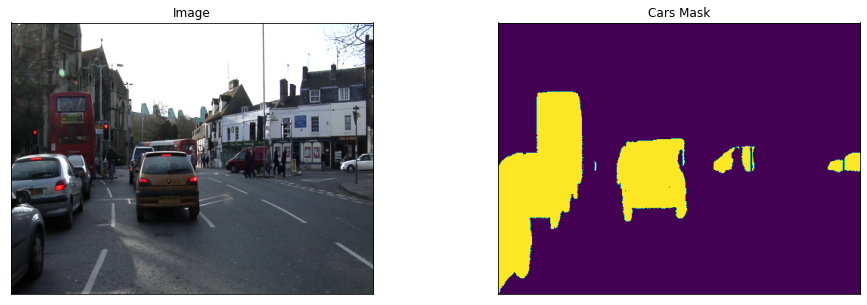

In [ ]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car'])

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [ ]:
import albumentations as albu


def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
# #### Visualize resulted augmented images and masks

# augmented_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
#     augmentation=get_training_augmentation(), 
#     classes=['car'],
# )

# # same image with different random transforms
# for i in range(3):
#     image, mask = augmented_dataset[1]
#     visualize(image=image, mask=mask.squeeze(-1))

In [ ]:
# pip install segmentation-models-pytorch

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 30 epochs
train_iou = []
valid_iou = []

max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    # print(valid_logs['iou_score'])
    train_iou.append(train_logs['iou_score'])
    valid_iou.append(valid_logs['iou_score'])

    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [00:08<00:00, 11.58it/s, dice_loss - 0.9019, iou_score - 0.1104]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:08<00:00, 11.56it/s, dice_loss - 0.8515, iou_score - 0.3605]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:08<00:00, 11.61it/s, dice_loss - 0.7747, iou_score - 0.5618]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:08<00:00, 11.54it/s, dice_loss - 0.7126, iou_score - 0.5489]

Epoch: 4
valid: 100%|██████████| 101/101 [00:08<00:00, 11.60it/s, dice_loss - 0.5936, iou_score - 0.6423]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:08<00:00, 11.54it/s, dice_loss - 0.5476, iou_score - 0.667]
Model saved!

Epoch: 6
valid: 100%|██████████| 101/101 [00:08<00:00, 11.60it/s, dice_loss - 0.5022, iou_score - 0.6449]

Epoch: 7
valid: 100%|██████████| 101/101 [00:08<00:00, 11.59it/s, dice_loss - 0.4821, iou_score - 0.6254]

Epoch: 8
valid: 100%|██████████| 101/101 [00:08<00:00, 11.50it/s, dice_loss - 0

In [ ]:
print(train_iou)
print(valid_iou)

[0.19470647459282814, 0.3825854429084321, 0.5610260480771894, 0.6332675571674885, 0.7002636660700257, 0.7014417913944825, 0.7395084681718247, 0.7344811856746671, 0.7550747226113858, 0.7640386165484138, 0.7851300071115083, 0.79132040752017, 0.7915076250615328, 0.786276006180307, 0.8069452837757443, 0.8272514317346658, 0.8122029576612555, 0.8253045522648356, 0.8259563135064165, 0.8249700795049252, 0.8189847443414773, 0.830629317008931, 0.8159413907838905, 0.8291285439677861, 0.846198048280633, 0.8228525817394258, 0.8496536055336827, 0.841143168832945, 0.8528234310772105, 0.8495379103266673, 0.8493192377297776, 0.8497427870397983, 0.8519720474015111, 0.8503512468027031, 0.8542867976686228, 0.8475693166255949, 0.8586772045363551, 0.8583023172357809, 0.8612747943919637, 0.8555911999681722]
[0.1104005171945042, 0.36053611066909574, 0.5617535099885853, 0.5489204692690136, 0.6423015128518476, 0.6670154796687114, 0.6448762129465958, 0.6254475157933708, 0.5519698649884119, 0.6783971830262303, 0.

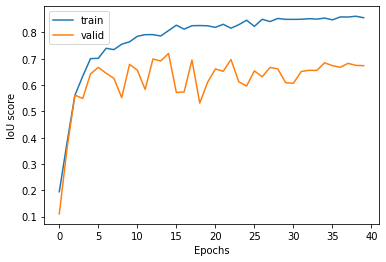

In [ ]:
from matplotlib import pyplot as plt
plt.plot(train_iou,label='train')
plt.plot(valid_iou,label='valid')
plt.xlabel("Epochs")
plt.ylabel("IoU score")
plt.legend()
# plt.show()



In [ ]:
# importing pandas as pd 
# import pandas as pd 
   
# # list of name, degree, score
# # scr = [90, 40, 80, 98]
   
# # dictionary of lists 
# dict = {'Unet++': valid} 
     
# df3 = pd.DataFrame(dict)
  
# # saving the dataframe
# df3.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/accuracy_over_epochs_valid.csv')

In [ ]:
import pandas as pd 

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/accuracy_over_epochs.csv')

df['DeepLabV3+'] = train_iou

print(df.to_string()) 

df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/accuracy_over_epochs.csv')

    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1    Unet++    PSPNet      Unet       FPN  DeepLabV3  DeepLabV3+
0            0             0               0                 0                   0                     0                       0  0.119958  0.309080  0.152337  0.439803   0.233904    0.194706
1            1             1               1                 1                   1                     1                       1  0.336743  0.562514  0.407913  0.680836   0.417266    0.382585
2            2             2               2                 2                   2                     2                       2  0.399525  0.622844  0.568526  0.705993   0.603727    0.561026
3            3             3               3                 3                   3                     3                       3  0.459062  0.667118  0.624155  0.743663   0.681986    0.633268
4            4             4            

In [ ]:
import pandas as pd 

df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/accuracy_over_epochs_valid.csv')

df2['DeepLabV3+'] = valid_iou

print(df2.to_string()) 

df2.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/accuracy_over_epochs_valid.csv')

    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  Unnamed: 0.1.1.1.1  Unnamed: 0.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1  Unnamed: 0.1.1.1.1.1.1.1    Unet++    PSPNet      Unet       FPN  DeepLabV3  DeepLabV3+
0            0             0               0                 0                   0                     0                       0                         0  0.071784  0.310879  0.101014  0.487175   0.132726    0.110401
1            1             1               1                 1                   1                     1                       1                         1  0.202731  0.470548  0.402130  0.601546   0.321884    0.360536
2            2             2               2                 2                   2                     2                       2                         2  0.163471  0.418065  0.471359  0.601584   0.432461    0.561754
3            3             3               3                 3                   3                     3                       3

In [ ]:
# load best saved checkpoint
best_model_UNET = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/Unet_best_model.pth')
best_model_UNETPlusPlus = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/Unet++_best_model.pth')
best_model_DeepLabV3 = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/DeepLabV3_best_model.pth')
best_model_DeepLabV3Plus = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/DeepLabV3+_best_model.pth')
best_model_PSPNet = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/PSPNet_best_model.pth')
best_model_FPNNet = torch.load('/content/gdrive/MyDrive/Colab Notebooks/Computer_vision_Assignment/FPN_best_model.pth')

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [ ]:
# evaluate model on test set
test_epoch_Unet = smp.utils.train.ValidEpoch(
    model=best_model_UNET,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

test_epoch_UnetPlusPlus = smp.utils.train.ValidEpoch(
    model=best_model_UNETPlusPlus,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

test_epoch_DeepLabV3 = smp.utils.train.ValidEpoch(
    model=best_model_DeepLabV3,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

test_epoch_DeepLabV3Plus = smp.utils.train.ValidEpoch(
    model=best_model_DeepLabV3Plus,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

test_epoch_PSP = smp.utils.train.ValidEpoch(
    model=best_model_PSPNet,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

test_epoch_FPN = smp.utils.train.ValidEpoch(
    model=best_model_FPNNet,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

print("Unet")
logs = test_epoch_Unet.run(test_dataloader)
print("Unet++")
logs = test_epoch_UnetPlusPlus.run(test_dataloader)
print("DeeplabV3")
logs = test_epoch_DeepLabV3.run(test_dataloader)
print("DeepLabV3+")
logs = test_epoch_DeepLabV3Plus.run(test_dataloader)
print("PSPNet")
logs = test_epoch_PSP.run(test_dataloader)
print("FPN")
logs = test_epoch_FPN.run(test_dataloader)

Unet
valid: 100%|██████████| 233/233 [00:10<00:00, 22.16it/s, dice_loss - 0.3713, iou_score - 0.7755]
Unet++
valid: 100%|██████████| 233/233 [00:22<00:00, 10.52it/s, dice_loss - 0.4033, iou_score - 0.7875]
DeeplabV3
valid: 100%|██████████| 233/233 [00:25<00:00,  9.30it/s, dice_loss - 0.3142, iou_score - 0.7218]
DeepLabV3+
valid: 100%|██████████| 233/233 [00:10<00:00, 22.76it/s, dice_loss - 0.2661, iou_score - 0.7539]
PSPNet
valid: 100%|██████████| 233/233 [00:06<00:00, 34.58it/s, dice_loss - 0.2472, iou_score - 0.682]
FPN
valid: 100%|██████████| 233/233 [00:09<00:00, 24.89it/s, dice_loss - 0.1911, iou_score - 0.7467]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

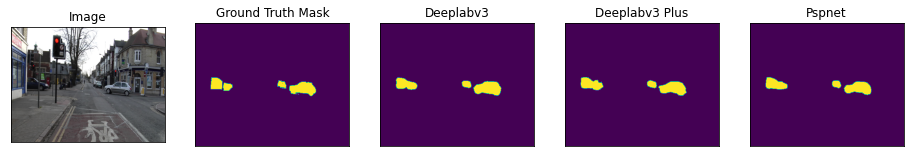

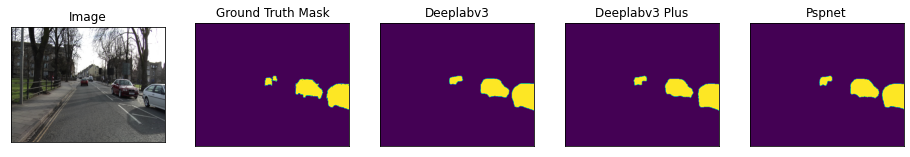

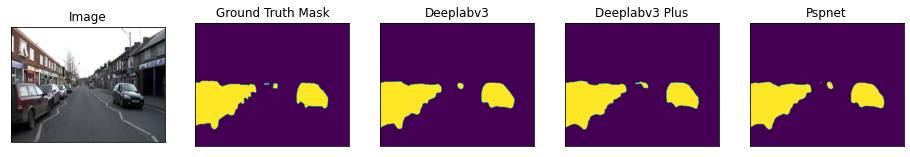

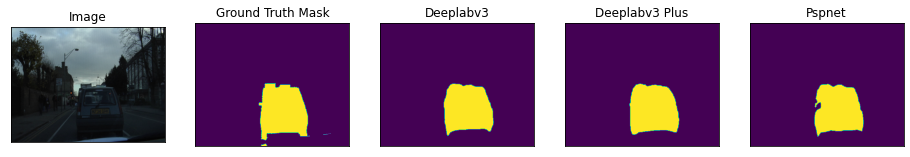

In [ ]:
for i in [8, 113, 43, 223]:
    # n = np.random.choice(len(test_dataset))
    # print(n)
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    pr_mask_unet = best_model_UNET.predict(x_tensor)
    pr_mask_unet = (pr_mask_unet.squeeze().cpu().numpy().round())

    pr_mask_unet_plus_plus = best_model_UNETPlusPlus.predict(x_tensor)
    pr_mask_unet_plus_plus = (pr_mask_unet_plus_plus.squeeze().cpu().numpy().round())
        
    pr_mask_deeplabV3 = best_model_DeepLabV3.predict(x_tensor)
    pr_mask_deeplabV3 = (pr_mask_deeplabV3.squeeze().cpu().numpy().round())

    pr_mask_deeplabV3Plus = best_model_DeepLabV3Plus.predict(x_tensor)
    pr_mask_deeplabV3Plus = (pr_mask_deeplabV3Plus.squeeze().cpu().numpy().round())

    pr_mask_psp = best_model_PSPNet.predict(x_tensor)
    pr_mask_psp = (pr_mask_psp.squeeze().cpu().numpy().round())

    pr_mask_fpn = best_model_FPNNet.predict(x_tensor)
    pr_mask_fpn = (pr_mask_fpn.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        # UNet=pr_mask_unet,
        # UNet_plus_plus=pr_mask_unet_plus_plus,
        DeeplabV3=pr_mask_deeplabV3,
        DeeplabV3_plus=pr_mask_deeplabV3Plus,
        PSPNet=pr_mask_psp,
        # FPNNet=pr_mask_fpn,

    )